# Exercise 17: Supernovae distance and redshift
####  Tasks

- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of  polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

#### If you have time (or later at home...)

- Repeat with Basis Function Regression and Kernel Regression
- Explore what happens when you change the number of datapoints and plot the resulting learning curves.
---

In [2]:
import numpy as np
import pylab as plt

from astroML.datasets import generate_mu_z
from astroML.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import NadarayaWatson

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


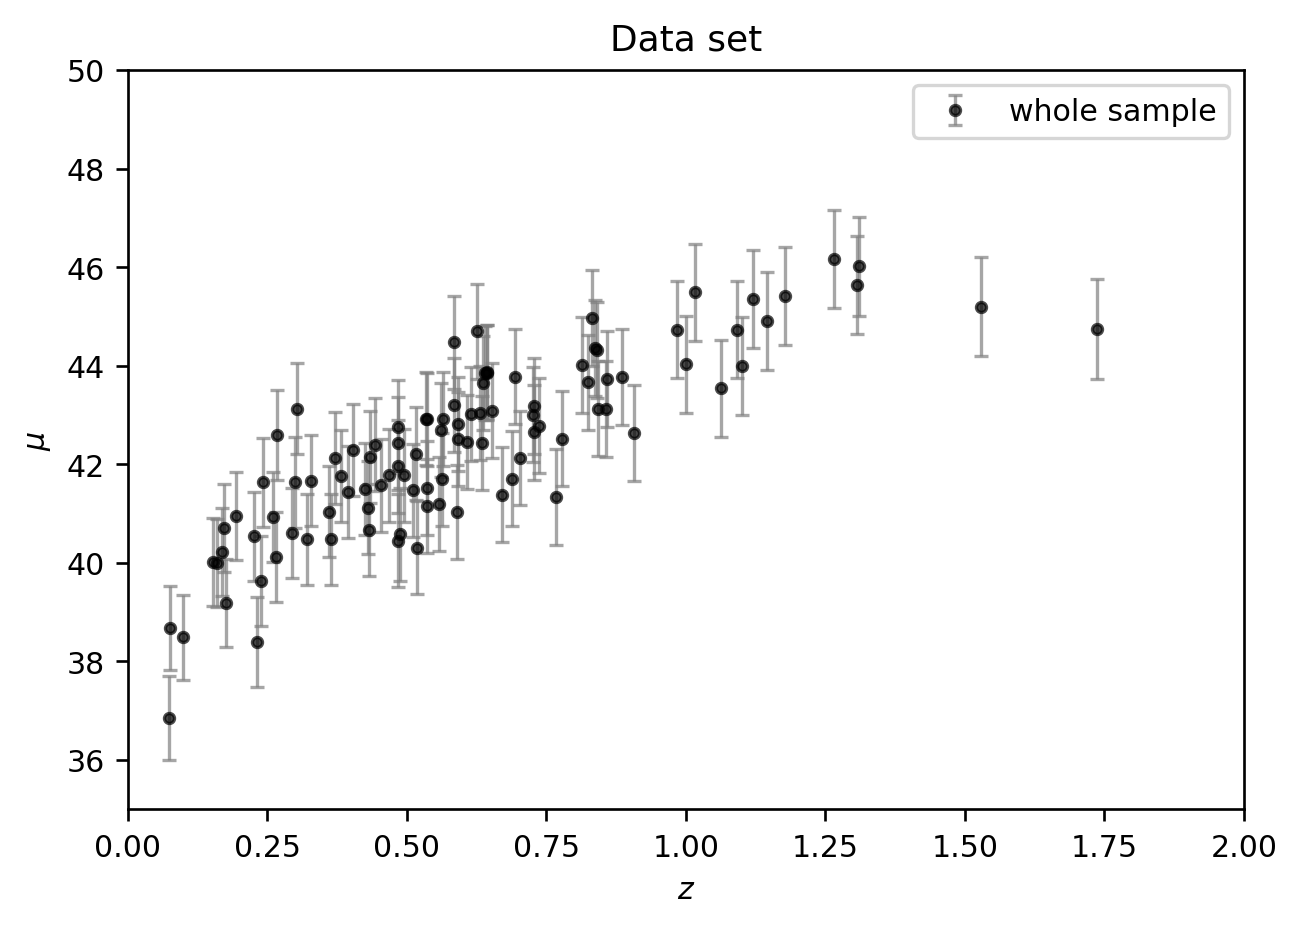

In [2]:
z_sample, mu_sample, dmu = np.asarray(generate_mu_z(100, random_state=1234))

#sorting the sample to ease access
args = np.argsort(z_sample)
z_sample = z_sample[args]
mu_sample = mu_sample[args]
dmu = dmu[args]

#Set TRUE for leaving 20 points as test set, FALSE to use all points
if False:
    z_train, z_test, mu_train, mu_test, dmu_train, dmu_test = \
        train_test_split(z_sample, mu_sample, dmu, test_size = 20, random_state=404)

    args = np.argsort(z_test)
    z_test = z_test[args]
    mu_test = mu_test[args]
    dmu_test = dmu_test[args]
    
    scores = [] #stores regressors scoring against test set

    def score_regressor(regressor):
        mu_pred = regressor.predict(z_test[:,None])
        score = [r2_score(mu_test, mu_pred), 
                mean_squared_error(mu_test, mu_pred)]
        return score

else:
    z_train = z_sample
    mu_train = mu_sample
    dmu_train = dmu

z = z_sample[:,None] #sklearn way

#-------  Plt params  ----------------
%config InlineBackend.figure_format='retina'
plt.rc('figure', figsize=(6, 4), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', 
             ecolor='gray', lw=1,label='whole sample',capsize = 2, alpha=0.7)
# plt.scatter(z_test,mu_test, label='test set')

plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend()
plt.title('Data set');

Our test set does not include the last 2 points, so they do not weight in testing, but only in validating if we want to include them

## Linear regression


In [3]:
linreg = LinearRegression()
linreg.fit(z, mu_sample, dmu)

# score_linear = score_regressor(linreg)
# scores.append(score_linear)

LinearRegression()

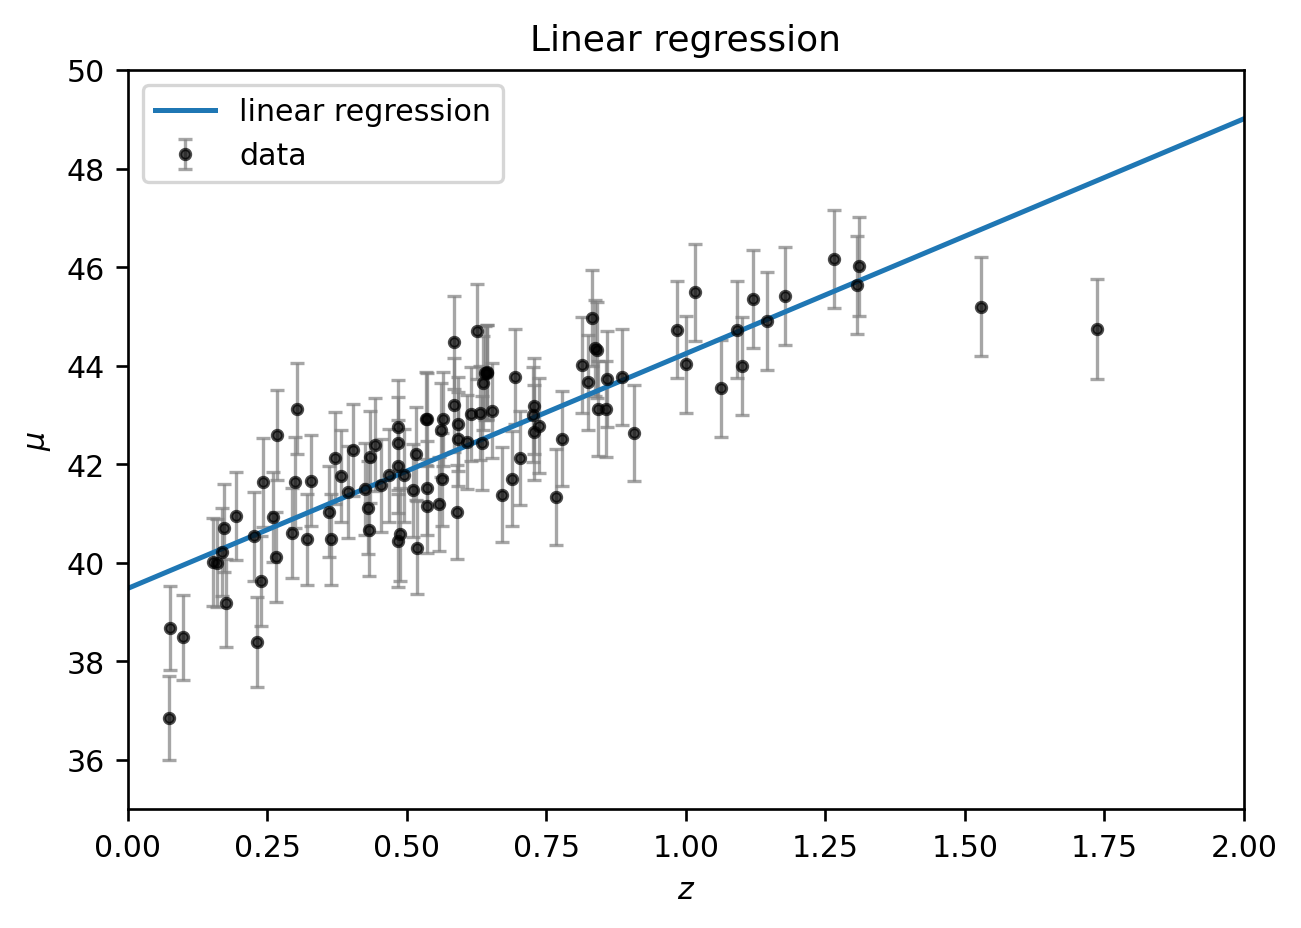

In [4]:
#Plot results
z_grid = np.linspace(0,2,100)[:, None]
mu_linear = linreg.predict(z_grid)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', 
             ecolor='gray', lw=1,label='data',capsize = 2, alpha=0.7)
plt.plot(z_grid, mu_linear,label='linear regression')
plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend()
plt.title('Linear regression');

## Polynomial

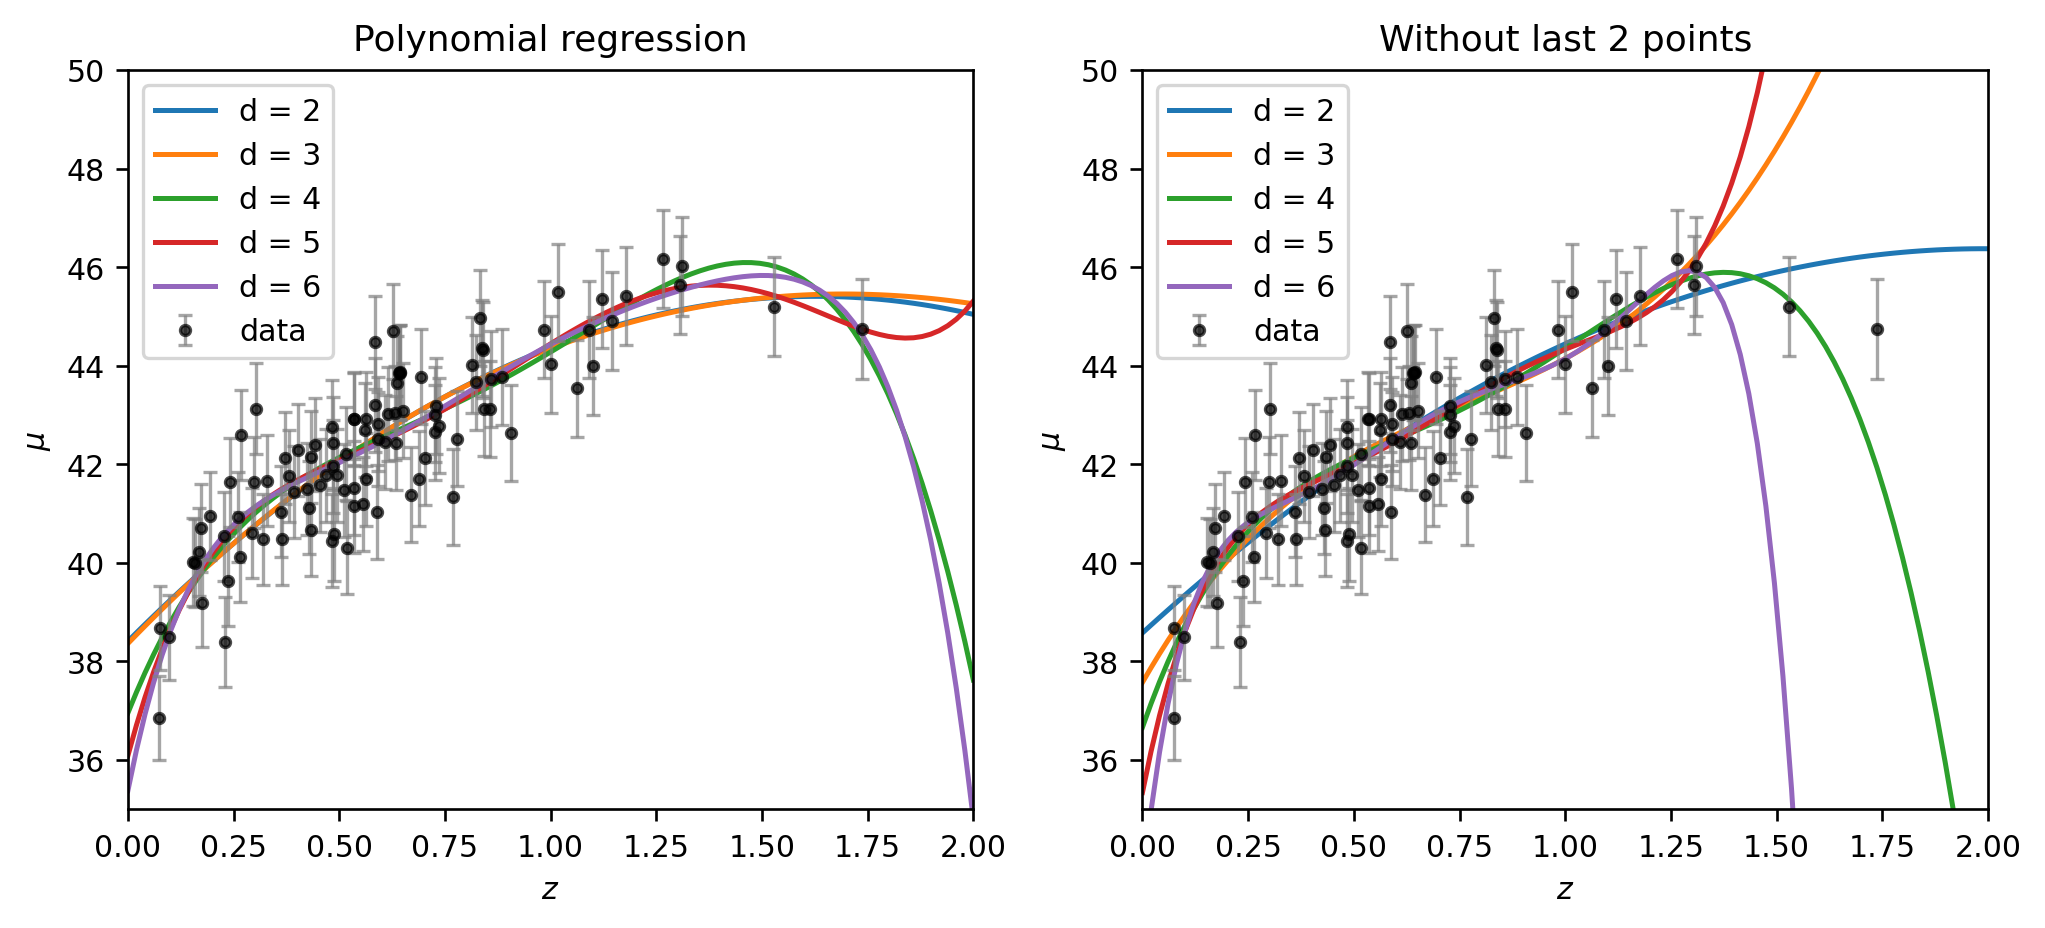

In [5]:
#-------  Plt params  ----------------
%config InlineBackend.figure_format='retina'
plt.rc('figure', figsize=(10, 4), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

degrees = np.arange(2, 7)
fig = plt.figure()

ax = fig.add_subplot(121)   

for d in degrees:
    polyreg = PolynomialRegression(d)
    polyreg.fit(z, mu_sample, dmu)
    mu_poly = polyreg.predict(z_grid)
    
    ax.plot(z_grid, mu_poly, label='d = %i' % d)

ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data',capsize = 2, alpha=0.7)
ax.legend()
ax.set_xlabel(r"$z$")
ax.set_ylabel("$\mu$")
ax.set_xlim(0,2)
ax.set_ylim(35,50)
ax.set_title('Polynomial regression');

ax = fig.add_subplot(122)   

for d in degrees:
    polyreg = PolynomialRegression(d)
    polyreg.fit(z[:-2], mu_sample[:-2], dmu[:-2])
    mu_poly = polyreg.predict(z_grid)
    
    ax.plot(z_grid, mu_poly, label='d = %i' % d)

ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data',capsize = 2, alpha=0.7)
ax.legend()
ax.set_xlabel(r"$z$")
ax.set_ylabel("$\mu$")
ax.set_xlim(0,2)
ax.set_ylim(35,50)
ax.set_title('Without last 2 points');

- Linear model clearly underfits data.
- d=2,3 fit quite well, maybe slight underfit
- d=4 captures also the last points well
- d=5,6 no great advantage by increasing model parameters (overfit?)

## Function Basis
We use gaussians as basis

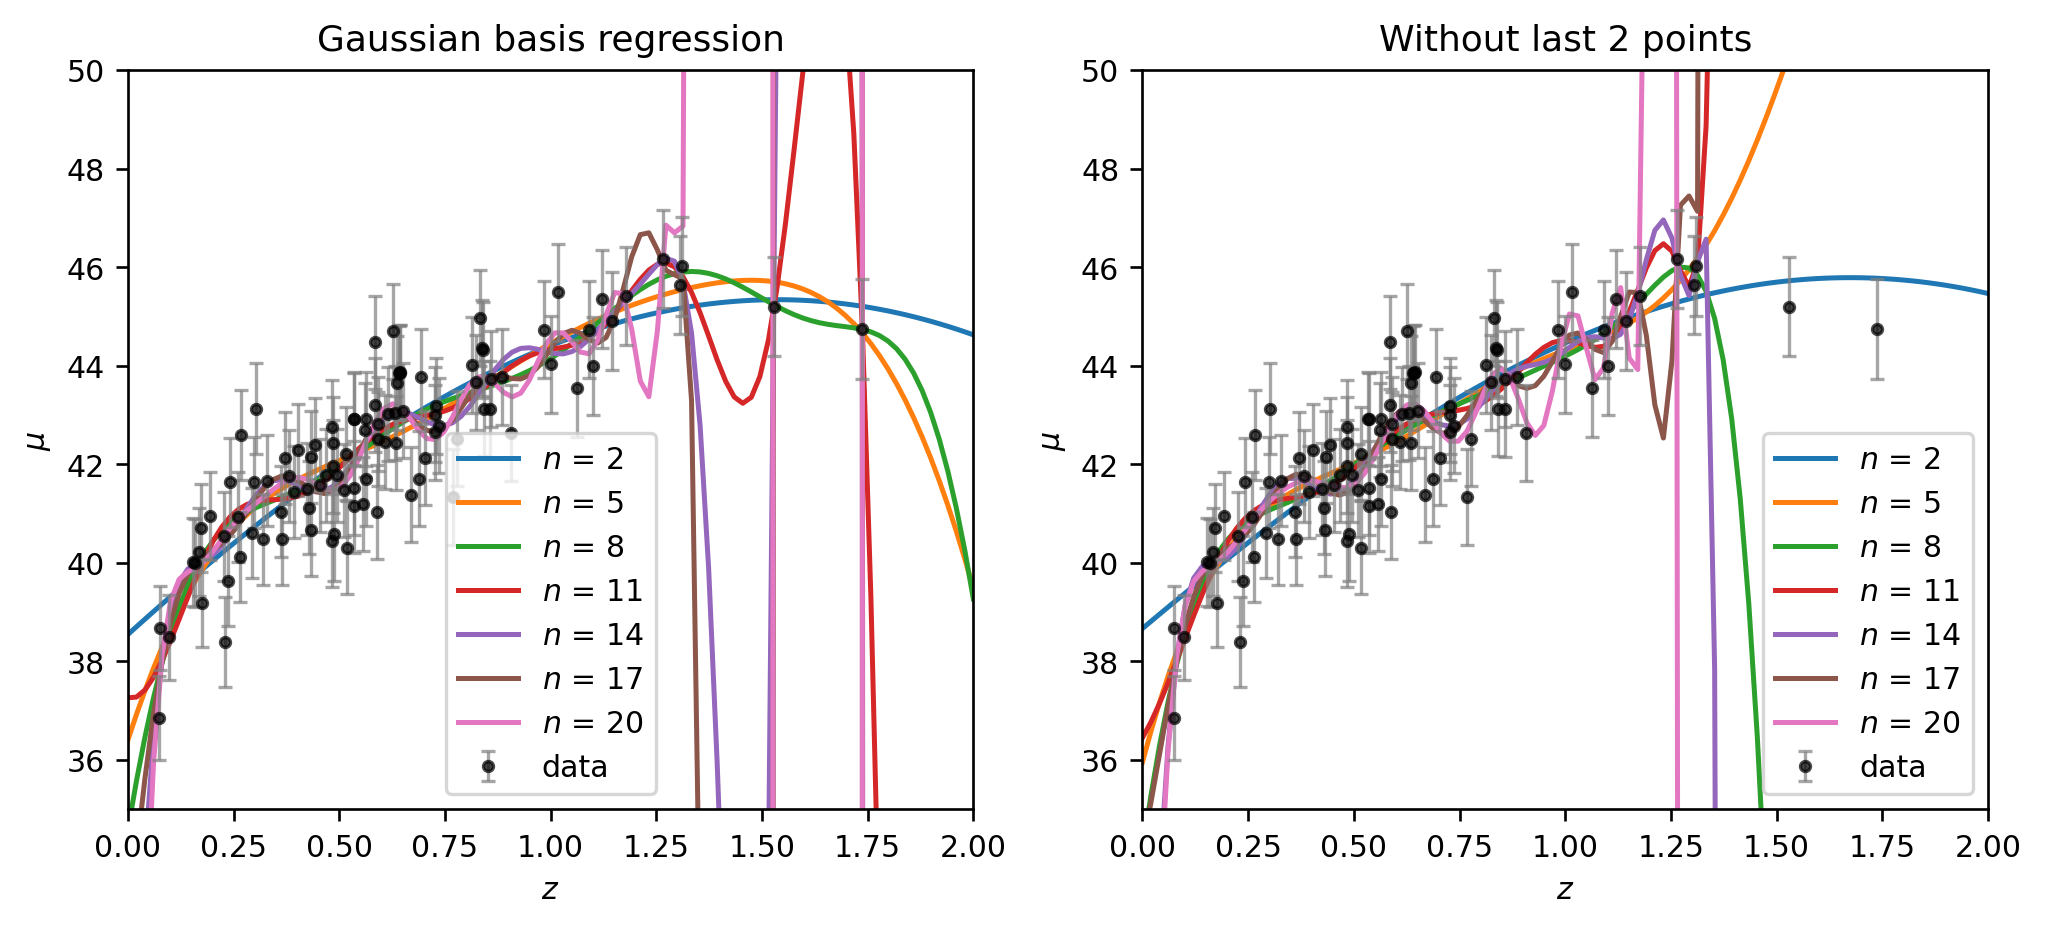

In [6]:
n_basis = np.arange(2, 21, 3)
fig = plt.figure()

ax = fig.add_subplot(121)   

for n in n_basis:
    gauss_mu = np.linspace(0, 2, n)[:, np.newaxis]
    sigma = gauss_mu[1] - gauss_mu[0]
    basis_model = BasisFunctionRegression(basis_func='gaussian', mu = gauss_mu, sigma = sigma)
    basis_model.fit(z, mu_sample, dmu)
    mu_basis = basis_model.predict(z_grid)
    
    ax.plot(z_grid, mu_basis, label=r'$n$ = %.i' % n)
    
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data',capsize = 2, alpha=0.7)
ax.legend()
ax.set_xlabel(r"$z$")
ax.set_ylabel("$\mu$")
ax.set_xlim(0,2)
ax.set_ylim(35,50)
ax.set_title('Gaussian basis regression');

ax = fig.add_subplot(122)   

for n in n_basis:
    gauss_mu = np.linspace(0, 2, n)[:, np.newaxis]
    sigma = gauss_mu[1] - gauss_mu[0]
    basis_model = BasisFunctionRegression(basis_func='gaussian', mu = gauss_mu, sigma = sigma)
    basis_model.fit(z[:-2], mu_sample[:-2], dmu[:-2])
    mu_basis = basis_model.predict(z_grid)
    
    ax.plot(z_grid, mu_basis, label=r'$n$ = %.i' % n)
    
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data',capsize = 2, alpha=0.7)
ax.legend()
ax.set_xlabel(r"$z$")
ax.set_ylabel("$\mu$")
ax.set_xlim(0,2)
ax.set_ylim(35,50)
ax.set_title('Without last 2 points');

## Kernel Regression

/home/fra/.local/lib/python3.8/site-packages/astroML/linear_model/kernel_regression.py:52: RuntimeWarning: invalid value encountered in true_divide
  return (K * self.y).sum(1) / K.sum(1)


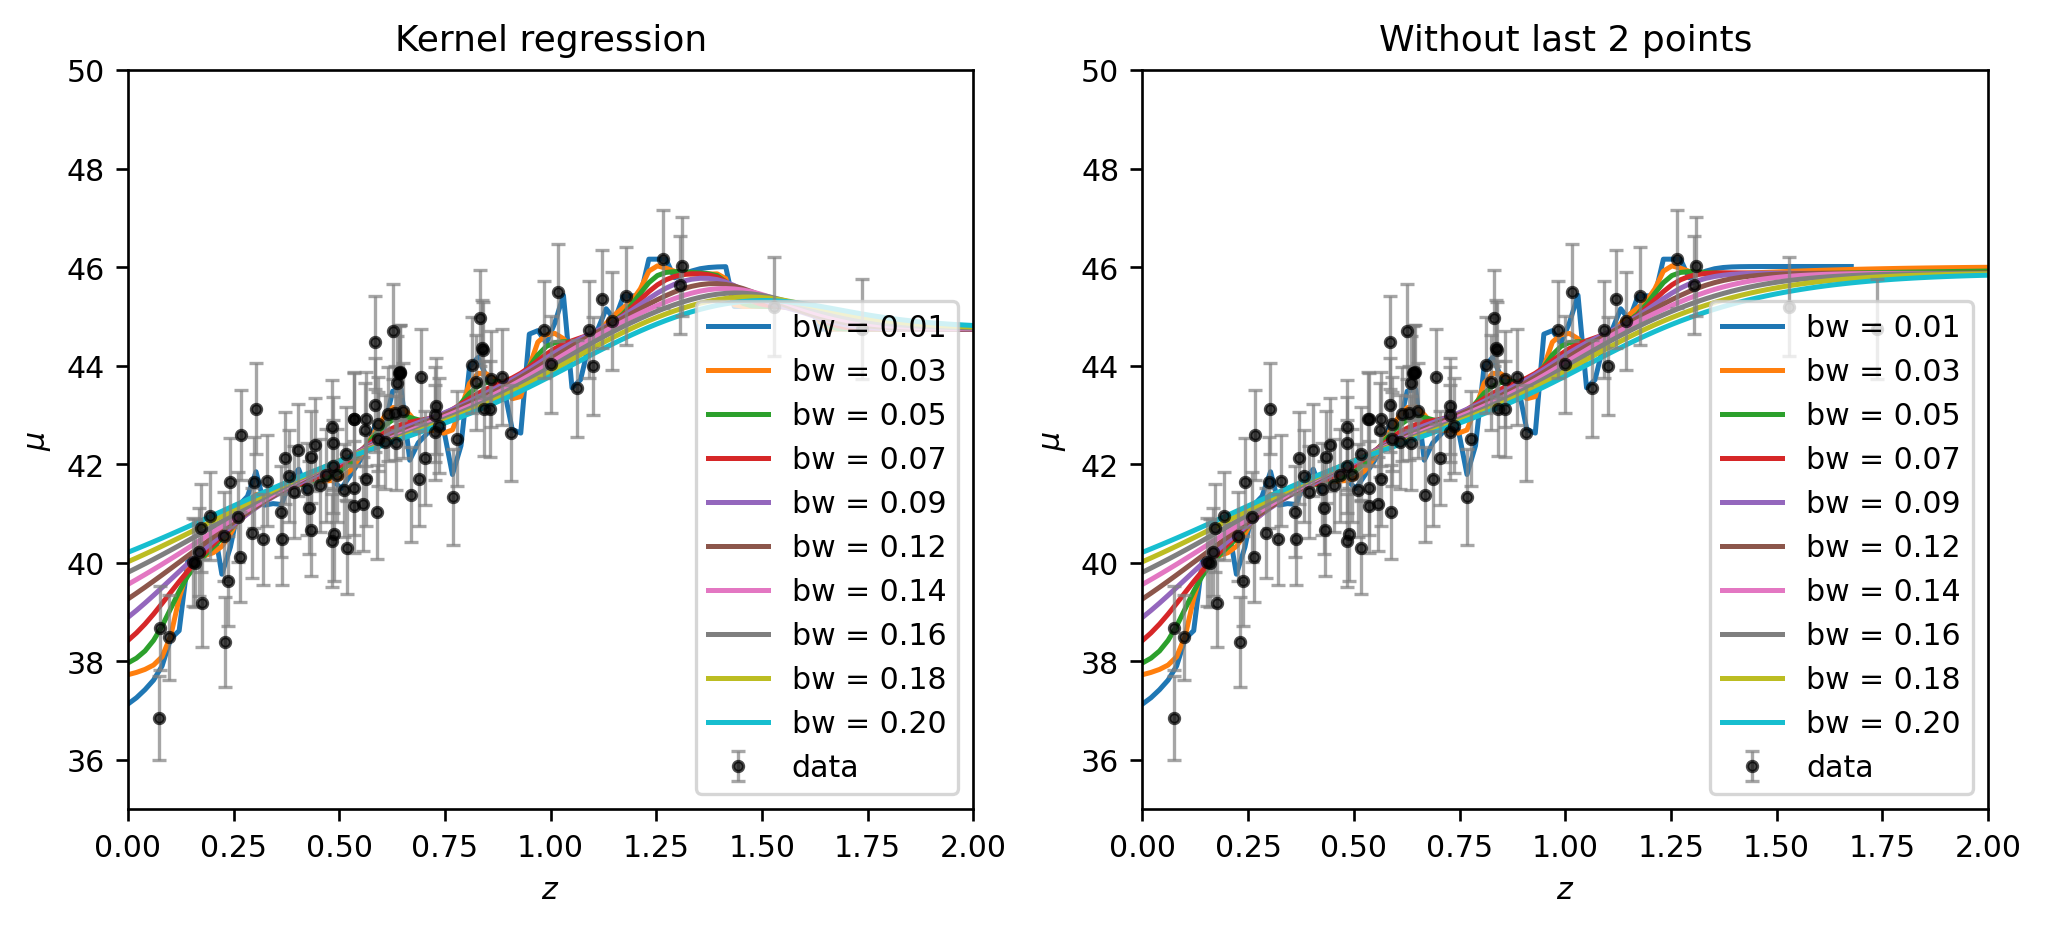

In [7]:
bw_list= np.linspace(0.01, 0.2, 10)

fig = plt.figure()

ax = fig.add_subplot(121)   

for bw in bw_list:
    
    kernel = NadarayaWatson(kernel='gaussian', h=bw)
    kernel.fit(z, mu_sample)
    mu_kernel = kernel.predict(z_grid)
    
    ax.plot(z_grid, mu_kernel, label= 'bw = %.2f' % bw)
    
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data',capsize = 2, alpha=0.7)
ax.legend()
ax.set_xlabel(r"$z$")
ax.set_ylabel("$\mu$")
ax.set_xlim(0,2)
ax.set_ylim(35,50)
ax.set_title('Kernel regression');

ax = fig.add_subplot(122)   

for bw in bw_list:
    
    kernel = NadarayaWatson(kernel='gaussian', h=bw)
    kernel.fit(z[:-2], mu_sample[:-2])
    mu_kernel = kernel.predict(z_grid)
    
    ax.plot(z_grid, mu_kernel, label= 'bw = %.2f' % bw)
    
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data',capsize = 2, alpha=0.7)
ax.legend()
ax.set_xlabel(r"$z$")
ax.set_ylabel("$\mu$")
ax.set_xlim(0,2)
ax.set_ylim(35,50)
ax.set_title('Without last 2 points');

# Cross validation
Draw again, so we can change number of points if we want

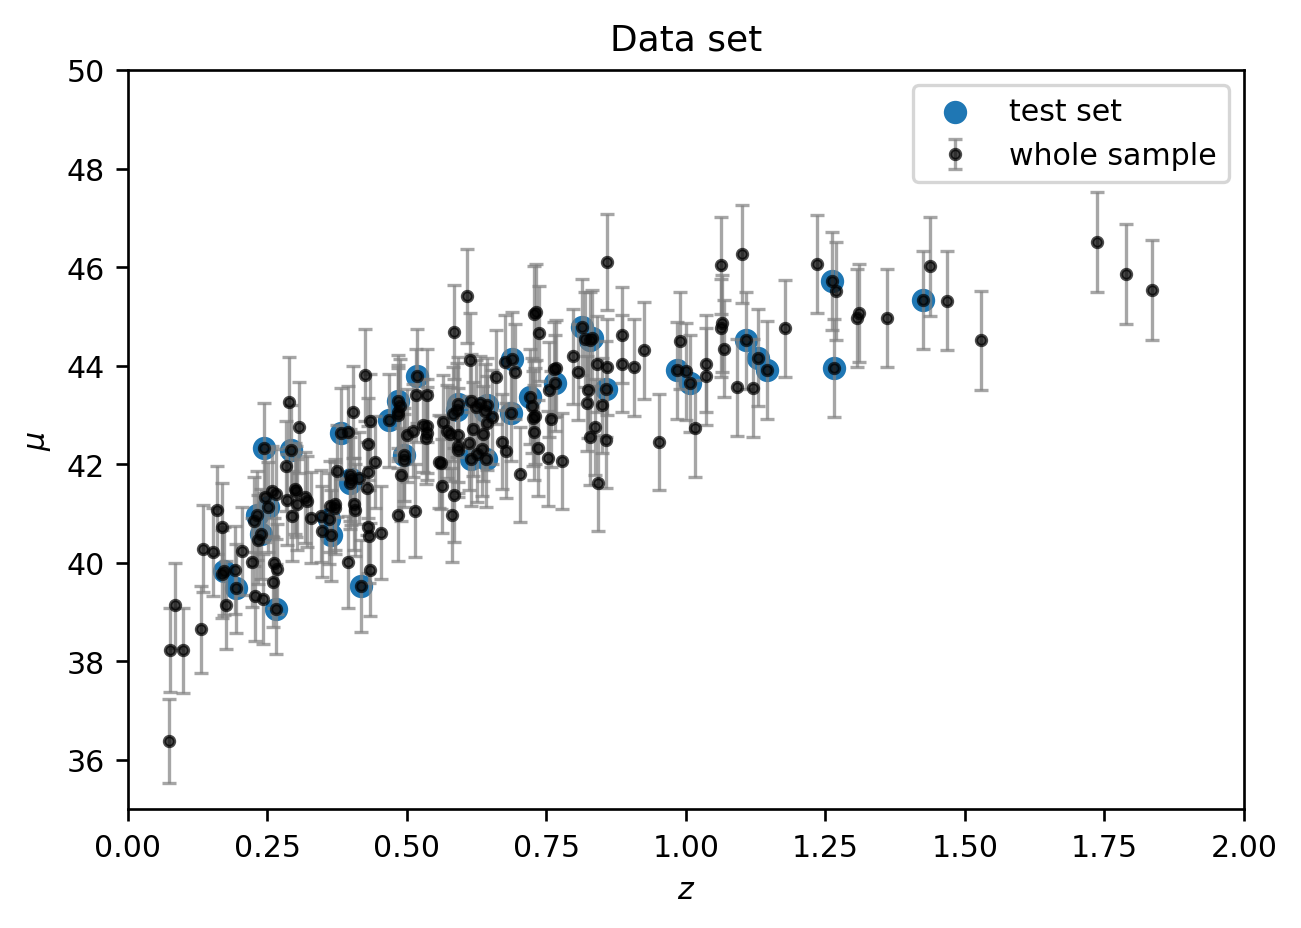

In [155]:
z_sample, mu_sample, dmu = np.asarray(generate_mu_z(200, random_state=1234))

#sorting the sample to ease access
args = np.argsort(z_sample)
z_sample = z_sample[args]
mu_sample = mu_sample[args]
dmu = dmu[args]

#Set TRUE for leaving 20% points as test set, FALSE to use all points
if True:
    z_train, z_test, mu_train, mu_test, dmu_train, dmu_test = \
        train_test_split(z_sample, mu_sample, dmu, test_size = 0.20, random_state=400)

    args = np.argsort(z_test)
    z_test = z_test[args]
    mu_test = mu_test[args]
    dmu_test = dmu_test[args]
    
    scores = [] #stores regressors scoring against test set

    def score_regressor(regressor):
        mu_pred = regressor.predict(z_test[:,None])
        score = [r2_score(mu_test, mu_pred), 
                mean_squared_error(mu_test, mu_pred)]
        return score

else:
    z_train = z_sample
    mu_train = mu_sample
    dmu_train = dmu

z = z_sample[:,None] #sklearn way

#-------  Plt params  ----------------
%config InlineBackend.figure_format='retina'
plt.rc('figure', figsize=(6, 4), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', 
             ecolor='gray', lw=1,label='whole sample',capsize = 2, alpha=0.7)
plt.scatter(z_test,mu_test, label='test set')

plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend()
plt.title('Data set');

In [133]:
# error = mean_squared_error #use Sklearn func
def error(y, y_fit):
    return np.sqrt(np.mean((y - y_fit)**2))

def K_cross_val_fit(K,model_func, param_list):
    ''' Arguments: 
    K = folds
    Model = func(p)
    param_list = grid of values of p to investigate'''
    
    # Create folds
    args = np.arange(0, len(z_train))
    np.random.shuffle(args)
    z_random = z_train[args]
    mu_random = mu_train[args]
    dmu_random = dmu_train[args]

    z_folds = np.asarray(np.split(z_random, K))
    mu_folds = np.asarray(np.split(mu_random, K))
    dmu_folds = np.asarray(np.split(dmu_random, K))

    k_list = np.arange(K)
    
    # Cross validation and fit
    err_val_mean = []
    err_train_mean = []

    start = 0

    for p in param_list: # Cycle on the hyperparameters
        model = model_func(p)
        
        err_train = []
        err_val = []
        
        for k in k_list: # At every hyperparams space point, compute k errors and average
            traincv_indexes = k_list[k_list != k]
            
            z_val = z_folds[k][:, None]
            z_traincv = z_folds[traincv_indexes].flatten()[:, None]
            
            mu_val = mu_folds[k]
            mu_traincv = mu_folds[traincv_indexes].flatten()
            
            dmu_val = z_folds[k]
            dmu_traincv = dmu_folds[traincv_indexes].flatten()
            
            model.fit(z_traincv, mu_traincv, dmu_traincv)
            mu_train_fit = model.predict(z_traincv)
            mu_val_fit = model.predict(z_val)
            
            err_train.append(error(mu_traincv, mu_train_fit))
            err_val.append(error(mu_val, mu_val_fit))
            
        err_train_mean.append(np.mean(np.array(err_train)))
        err_val_mean.append(np.mean(np.array(err_val)))
    
    best_par = param_list[np.argmin(err_val_mean)]
    
    return err_train_mean, err_val_mean, best_par

## Polynomial

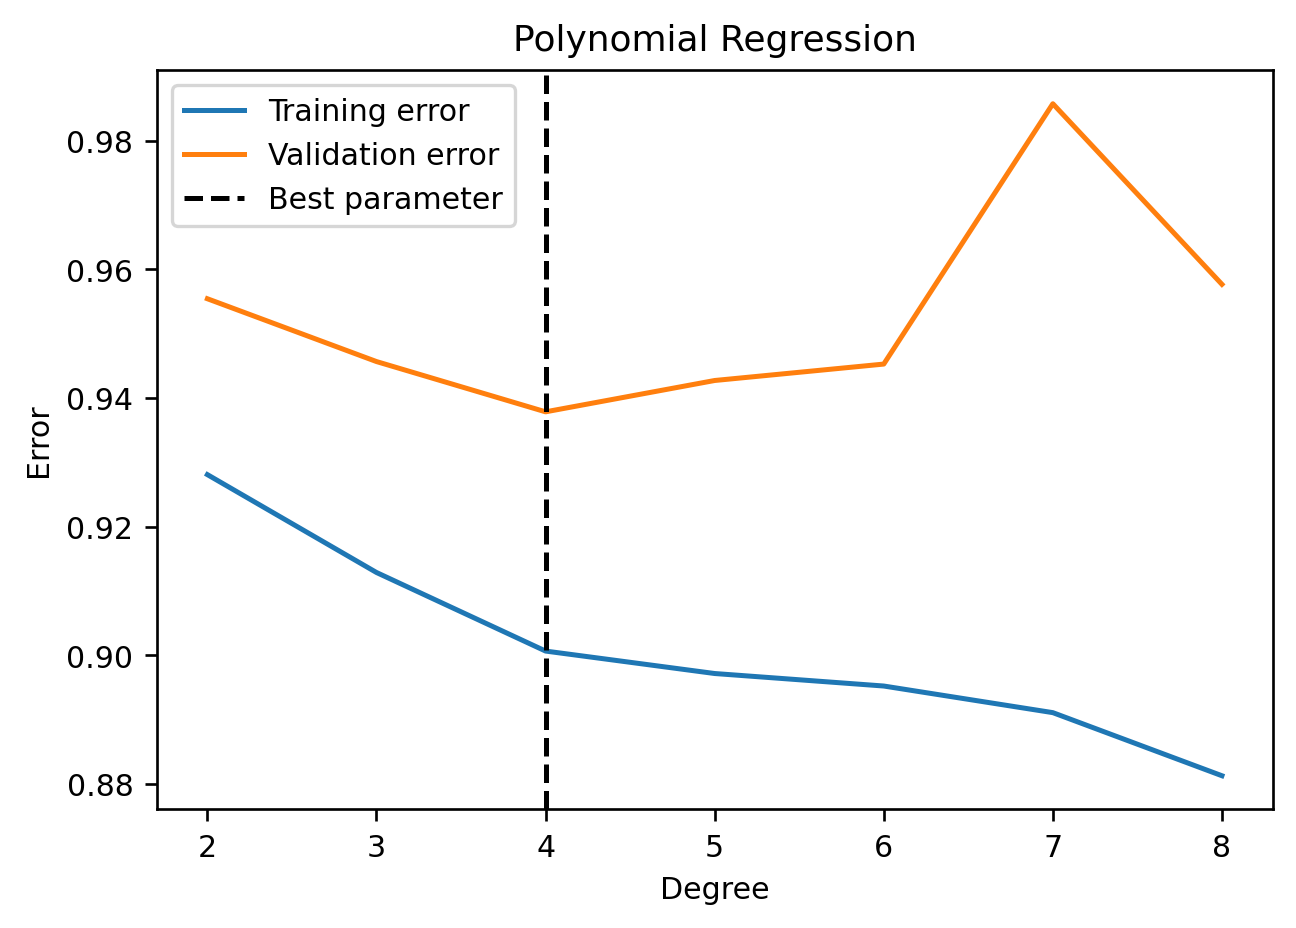

In [156]:
deg_list = np.arange(2, 9)
err_train_mean, err_val_mean, best_deg = K_cross_val_fit(4,PolynomialRegression,deg_list)

plt.plot(deg_list,err_train_mean, label='Training error' )
plt.plot(deg_list,err_val_mean, label='Validation error')
plt.axvline(best_deg, ls='--', color='k', label='Best parameter')
plt.title('Polynomial Regression')
plt.xlabel('Degree')
plt.ylabel('Error')
plt.legend();

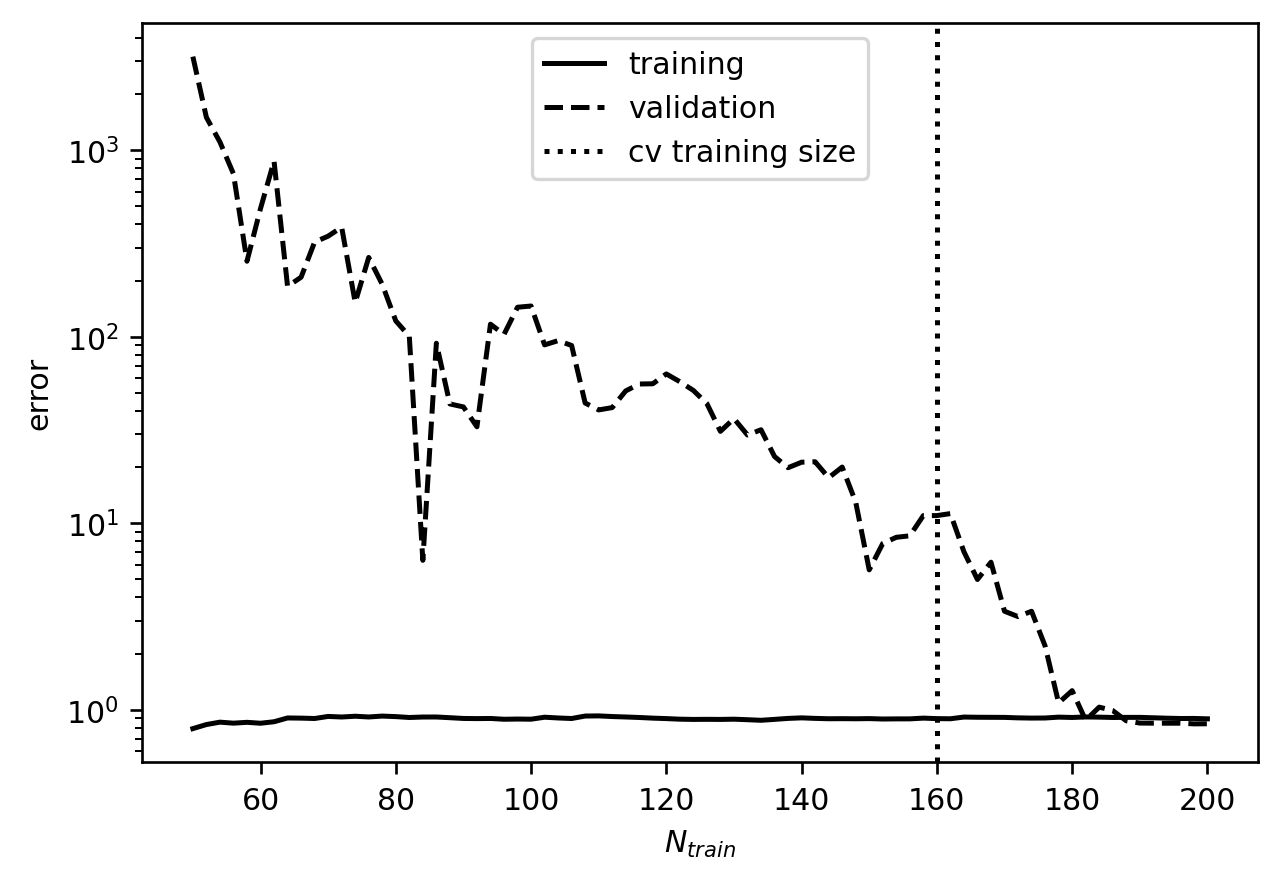

In [158]:
# Plot learning curve
model = PolynomialRegression(best_deg)

N_list = np.arange(50, len(z_sample) + 1, 2)

err_train = []
err_val = []

z_sample_sk = z_sample[:,None]
z_train_sk = z_train[:,None]
z_test_sk = z_test[:,None]

for n in N_list:
    model.fit(z_sample_sk[:n], mu_sample[:n], dmu[:n])
    mu_train_fit = model.predict(z_sample_sk[:n])
    mu_test_fit = model.predict(z_test_sk)
    err_train.append(error(mu_sample[:n], mu_train_fit))
    err_val.append(error(mu_test, mu_test_fit))

plt.plot(N_list, err_train, c='k', label='training')
plt.plot(N_list, err_val, c='k', ls='--', label='validation')

plt.axvline(len(z_train), c = 'k', ls = ':', label = 'cv training size')

plt.xlabel(r'$N_{train}$')
plt.ylabel('error')
plt.yscale('log')
plt.legend()
plt.show()

From this learning curve it appears that our model is crucially dependent from having enough points to be able to predict well.

## Function basis

In [139]:
def BasisFunctionReg_func(n):
    gauss_mu = np.linspace(0, 2, n)[:, np.newaxis]
    sigma = gauss_mu[1] - gauss_mu[0]
    return BasisFunctionRegression(basis_func='gaussian', mu = gauss_mu, sigma = sigma)

Best parameter = 5


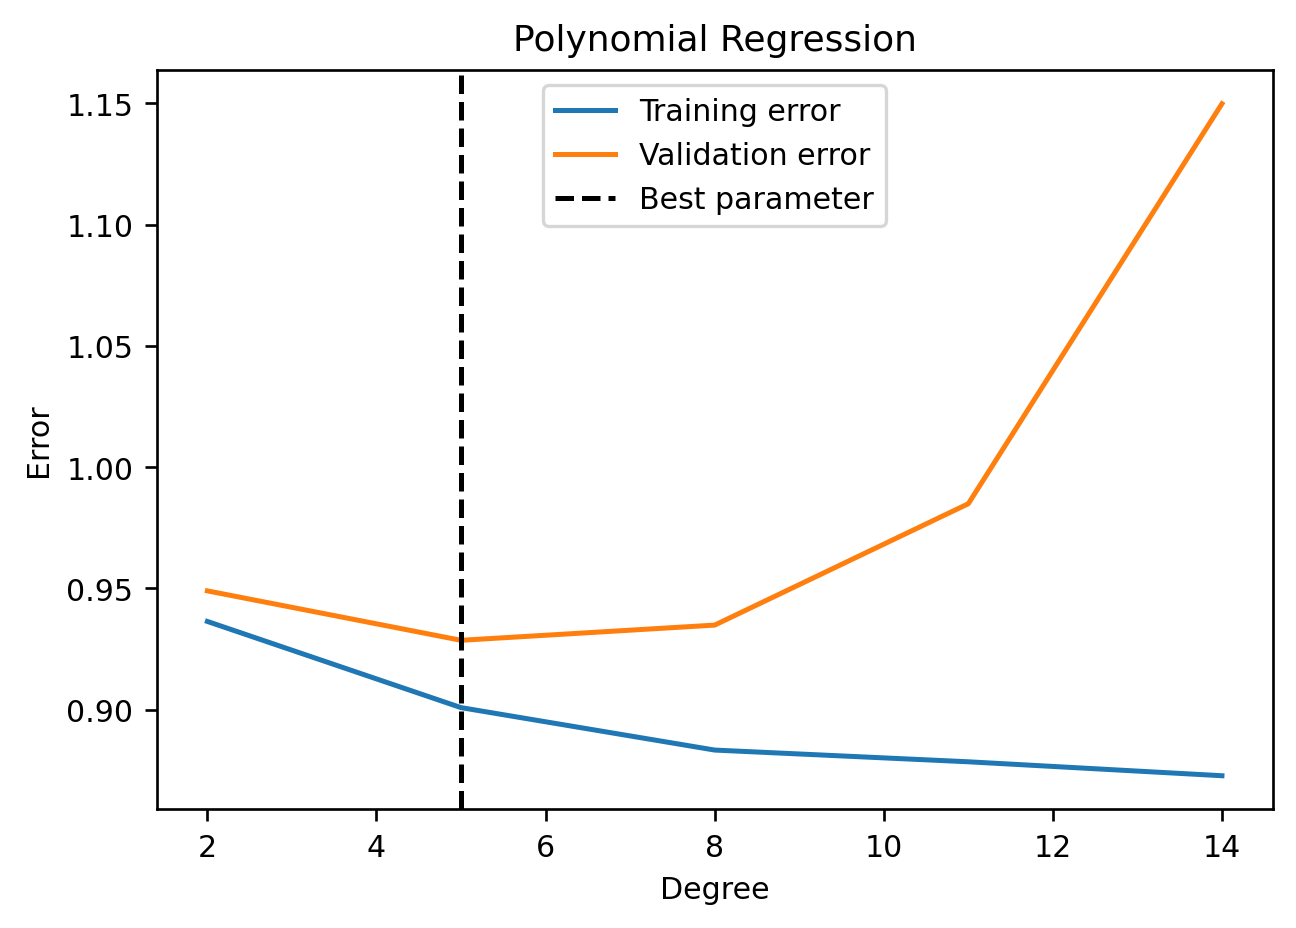

In [146]:
n_list = np.arange(2, 15, 3)
err_train_mean, err_val_mean, best_n = K_cross_val_fit(4,BasisFunctionReg_func,n_list)

print(f'Best parameter = {best_n}')
plt.plot(n_list,err_train_mean, label='Training error' )
plt.plot(n_list,err_val_mean, label='Validation error')
plt.axvline(best_n, ls='--', color='k', label='Best parameter')
plt.title('Polynomial Regression')
plt.xlabel('Degree')
plt.ylabel('Error')
plt.legend();

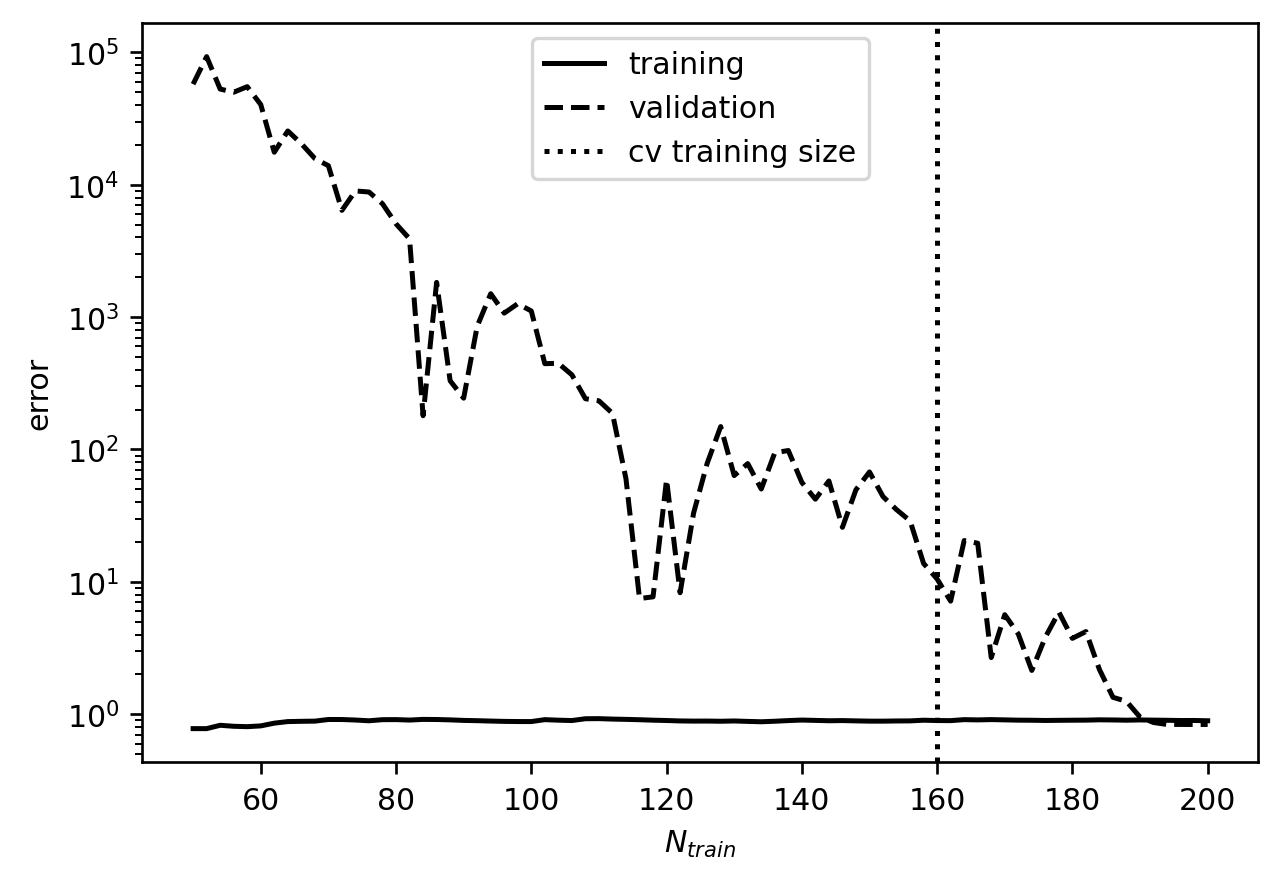

In [147]:
model = BasisFunctionReg_func(best_n)


N_list = np.arange(50, len(z_sample) + 1, 2)
err_train = []
err_val = []

for n in N_list:
    model.fit(z_sample_sk[:n], mu_sample[:n], dmu[:n])
    mu_train_fit = model.predict(z_sample_sk[:n])
    mu_test_fit = model.predict(z_test_sk)
    err_train.append(error(mu_sample[:n], mu_train_fit))
    err_val.append(error(mu_test, mu_test_fit))

plt.plot(N_list, err_train, c='k', label='training')
plt.plot(N_list, err_val, c='k', ls='--', label='validation')
plt.axvline(len(z_train), c = 'k', ls = ':', label = 'cv training size')
plt.xlabel(r'$N_{train}$')
plt.ylabel('error')
plt.yscale('log')
plt.legend()
plt.show()

## Kernel regression

In [149]:
def KernelRegression_func(bw):
    return NadarayaWatson(kernel='gaussian', h=bw)

Best parameter = 0.05888888888888889


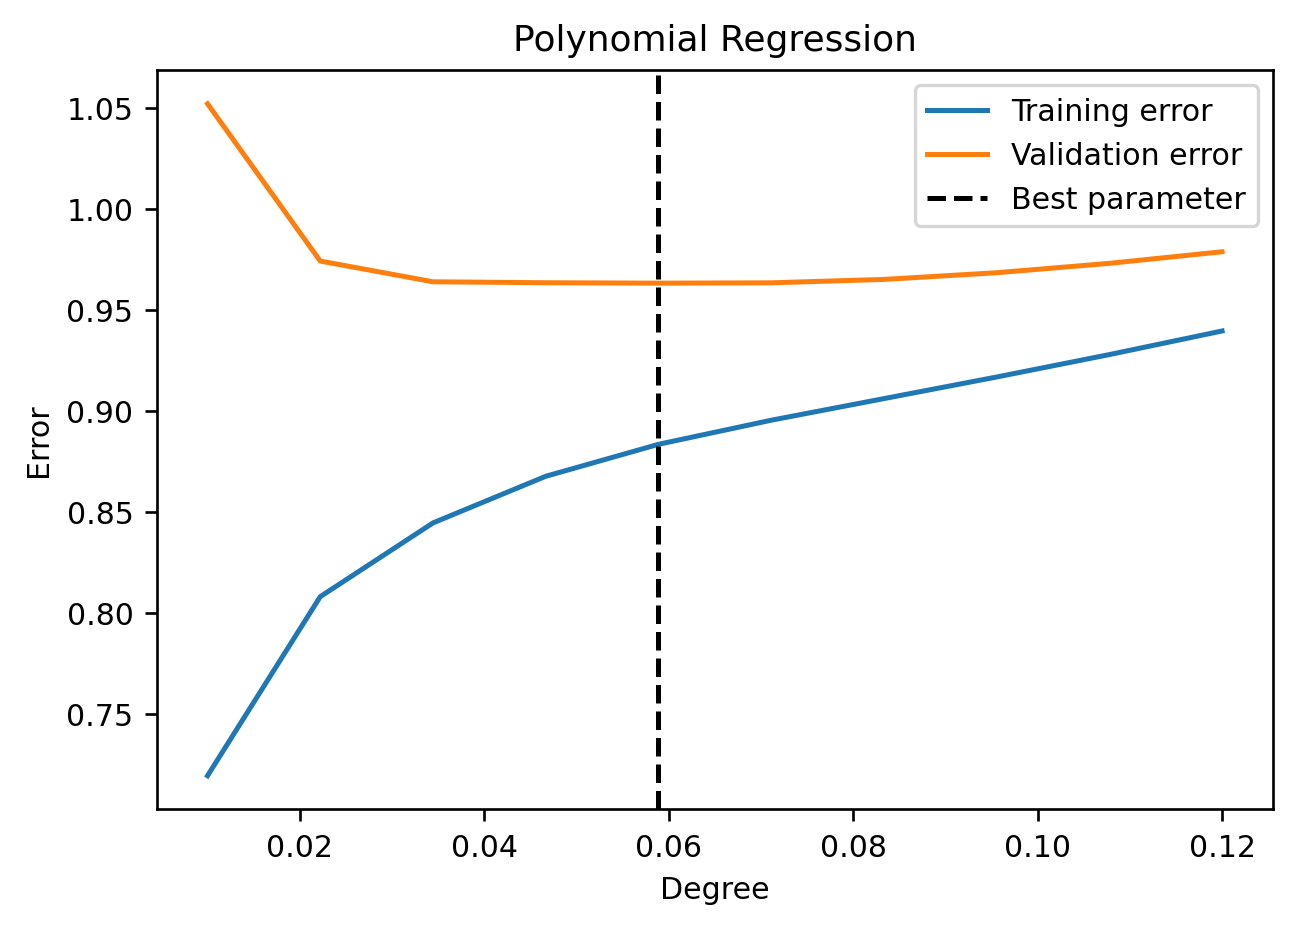

In [174]:
bw_list= np.linspace(0.01, 0.12, 10)

err_train_mean, err_val_mean, best_bw = K_cross_val_fit(4,KernelRegression_func, bw_list)

print(f'Best parameter = {best_bw}')
plt.plot(bw_list,err_train_mean, label='Training error' )
plt.plot(bw_list,err_val_mean, label='Validation error')
plt.axvline(best_bw, ls='--', color='k', label='Best parameter')
plt.title('Polynomial Regression')
plt.xlabel('Degree')
plt.ylabel('Error')
plt.legend();

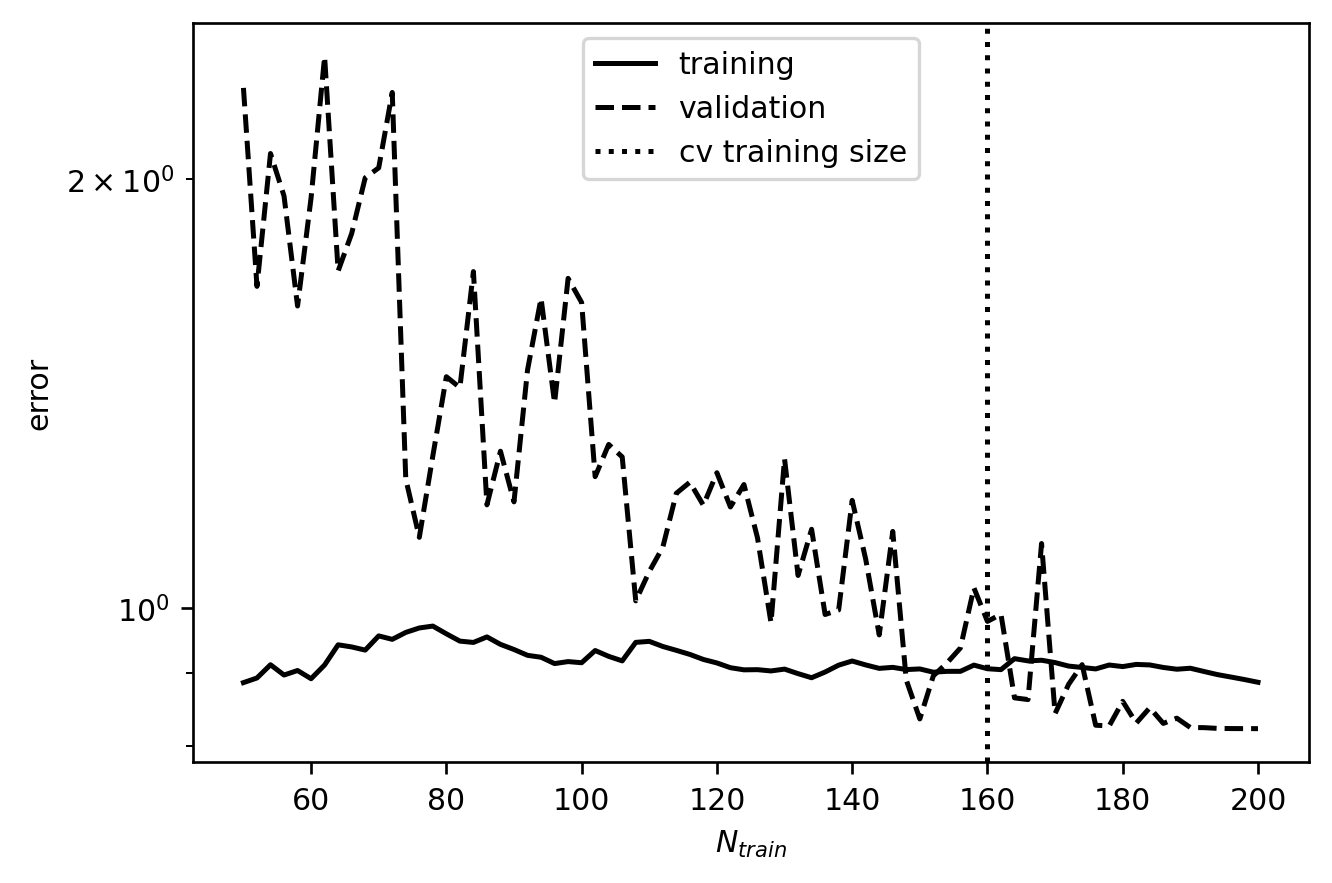

In [175]:
model = KernelRegression_func(best_bw)


N_list = np.arange(50, len(z_sample) + 1, 2)
err_train = []
err_val = []

for n in N_list:
    model.fit(z_sample_sk[:n], mu_sample[:n], dmu[:n])
    mu_train_fit = model.predict(z_sample_sk[:n])
    mu_test_fit = model.predict(z_test_sk)
    err_train.append(error(mu_sample[:n], mu_train_fit))
    err_val.append(error(mu_test, mu_test_fit))

plt.plot(N_list, err_train, c='k', label='training')
plt.plot(N_list, err_val, c='k', ls='--', label='validation')
plt.axvline(len(z_train), c = 'k', ls = ':', label = 'cv training size')
plt.xlabel(r'$N_{train}$')
plt.ylabel('error')
plt.yscale('log')
plt.legend()
plt.show()

# Visual comparison

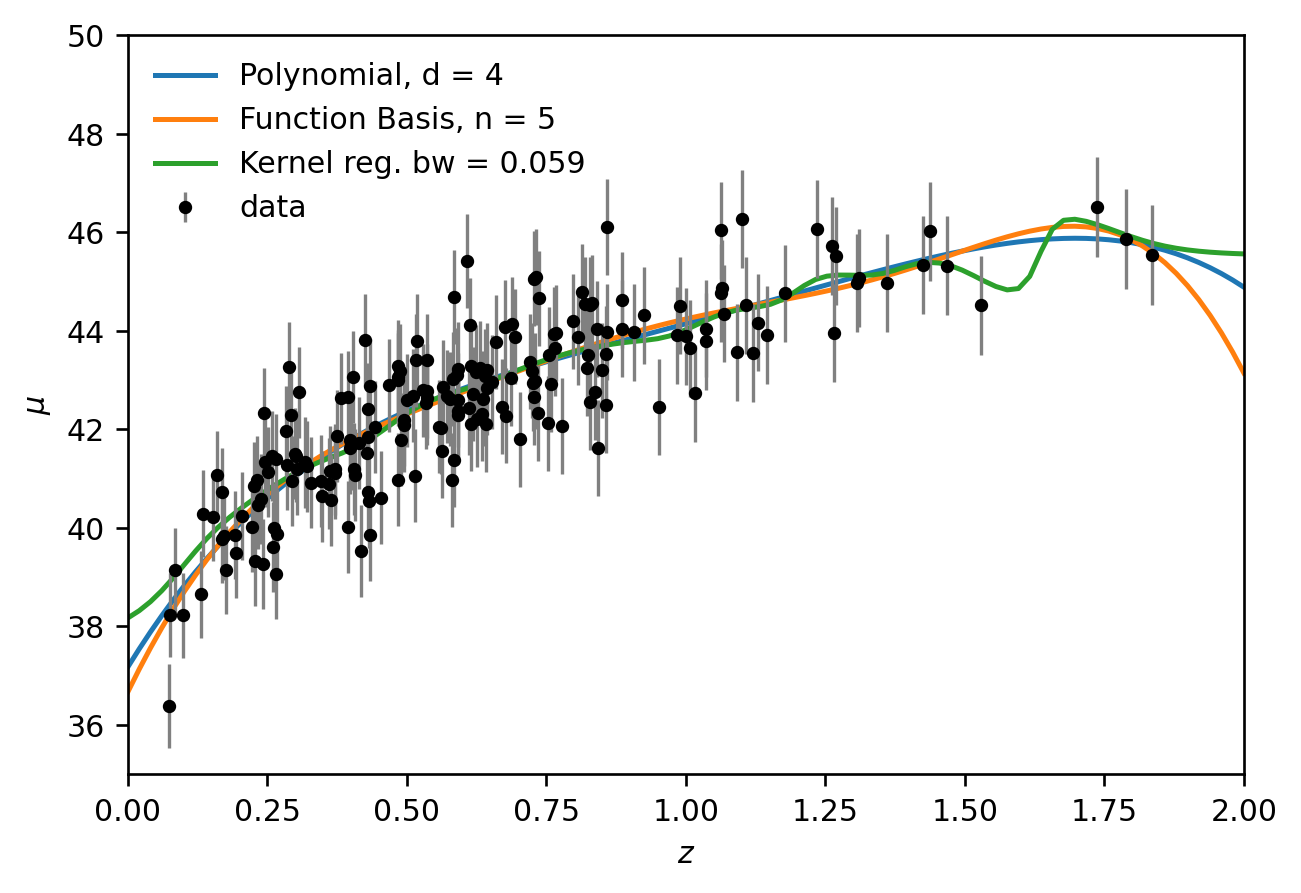

In [176]:
z_grid = np.linspace(0,2,100)[:, None]

models = [PolynomialRegression, BasisFunctionReg_func, KernelRegression_func]
params = [best_deg, best_n, best_bw]
labels = [f'Polynomial, d = {best_deg}', f'Function Basis, n = {best_n}', f'Kernel reg. bw = {best_bw:.2}']

for mod, best_p, label in zip(models,params, labels):
    
    model = mod(best_p)
    model.fit(z, mu_sample, dmu)
    mu_poly = model.predict(z_grid)
    plt.plot(z_grid, mu_poly, label=label)


plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(frameon = False)
plt.show()

It seems that Kernel regression is more prone to overfitting (strange feature at z=1.75)